In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

api = wandb.Api(timeout=19)

In [3]:
import pandas as pd

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

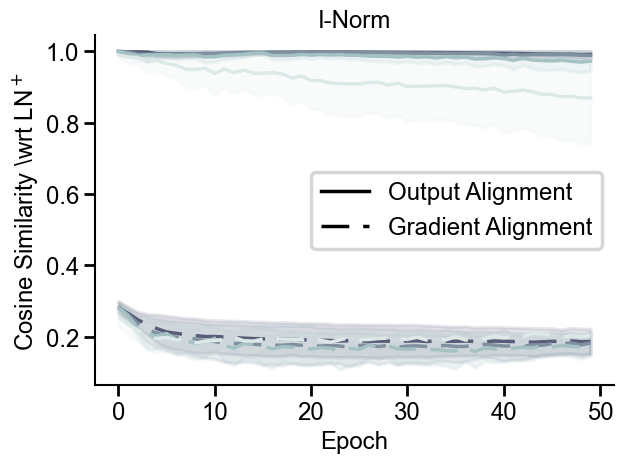

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm, colors, lines

# Truncate colormap
def truncate_colormap(cmap, minval=0.0, maxval=0.85, n=100):
    return colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

# Setup
brightness_factors = [0, 0.25, 0.5, 0.75]
alignment_types = ['output_alignment_', 'gradient_alignment_']
layers_to_average = ["fc0", "fc1"]

# Colormap for brightness
trunc_bone = truncate_colormap(cm.get_cmap('bone'), 0.4, 0.9)
norm = colors.Normalize(vmin=min(brightness_factors), vmax=max(brightness_factors))
scalar_map = cm.ScalarMappable(norm=norm, cmap=trunc_bone)

# Plot
fig, ax = plt.subplots()

for a_idx, alignment_prefix in enumerate(alignment_types):
    linestyle = 'solid' if a_idx == 0 else 'dashed'

    for bright in brightness_factors:
        color = trunc_bone(norm(bright))
        all_layer_data = []

        for layer in layers_to_average:
            runs = fetch_runs(
                api,
                entity='project_danns',
                project_name='Luminosity_LNHomeostasis',
                filters={
                    "config.dataset": "fashionmnist",
                    "config.brightness_factor": bright,
                    "config.homeostasis": 1,
                    "config.normtype": 0,
                    "config.normtype_detach": 1,
                    "config.excitation_training": 1,
                    "config.layer_norm": None,
                    "config.use_testset": True,
                    "config.ln_feedback": 'full',
                    "config.lambda_homeo": 0.01,
                },
                order="-summary_metrics.test_acc"
            )

            layer_histories = []
            for run in runs:
                hist = run.history(samples=5000000, keys=[f"{alignment_prefix}{layer}"])
                if f"{alignment_prefix}{layer}" in hist:
                    values = hist[f"{alignment_prefix}{layer}"].astype(float).values
                    if not np.any(np.isnan(values)):
                        layer_histories.append(values)

            if layer_histories:
                min_len = min(len(arr) for arr in layer_histories)
                # print(f'{alignment_prefix} - {bright} - {layer} - {min_len}')
                truncated = [arr[:min_len] for arr in layer_histories]
                stacked = np.stack(truncated)
                all_layer_data.append(stacked)

        if all_layer_data:
            all_layer_data = np.stack(all_layer_data)  # [2, num_runs, T]
            mean_per_layer = np.mean(all_layer_data, axis=1)  # [2, T]
            avg_across_layers = np.mean(mean_per_layer, axis=0)
            std_across_layers = np.std(mean_per_layer, axis=0)

            ax.plot(avg_across_layers, color=color, linestyle=linestyle)
            ax.fill_between(
                range(len(avg_across_layers)),
                avg_across_layers - std_across_layers,
                avg_across_layers + std_across_layers,
                alpha=0.15,
                color=color
            )

# Axis formatting
ax.set_title("I-Norm")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cosine Similarity \wrt LN$^+$")
ax.yaxis.set_major_formatter(ScalarFormatter())

# Colorbar for brightness levels
# cbar = plt.colorbar(scalar_map, ax=ax, orientation='vertical', pad=0.02)
# cbar.set_label('Brightness Factor')

# Legend for line styles only
legend_lines = [
    lines.Line2D([], [], color='black', linestyle='solid', label='Output Alignment'),
    lines.Line2D([], [], color='black', linestyle='dashed', label='Gradient Alignment')
]
ax.legend(handles=legend_lines, loc='center right')

plt.tight_layout()
plt.savefig("figure3b.svg", format="svg")

gradient_alignment_ - 0 - fc0 - 50
gradient_alignment_ - 0 - fc1 - 50
gradient_alignment_ - 0.5 - fc0 - 50
gradient_alignment_ - 0.5 - fc1 - 50
gradient_alignment_ - 0.75 - fc0 - 50
gradient_alignment_ - 0.75 - fc1 - 50


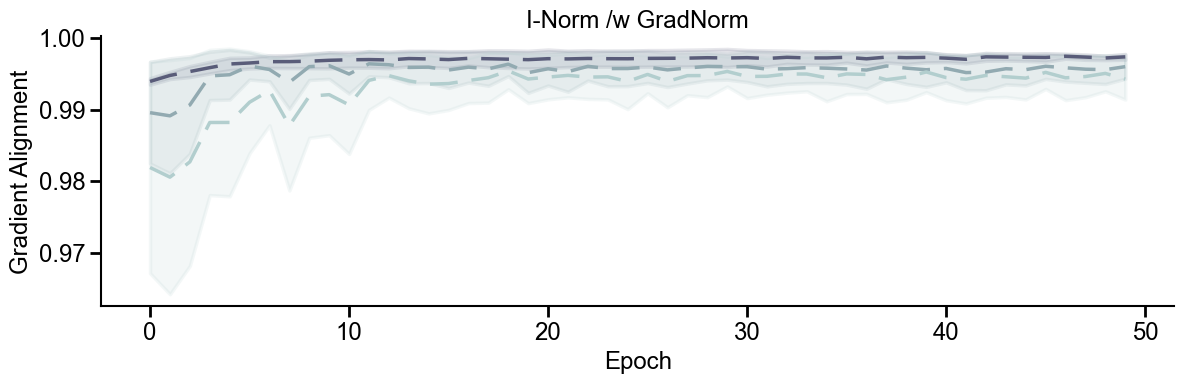

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm, colors, lines

# Truncate colormap
def truncate_colormap(cmap, minval=0.0, maxval=0.85, n=100):
    return colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

# Setup
brightness_factors = [0, 0.5, 0.75, 1]
alignment_prefix = 'gradient_alignment_'
layers_to_average = ["fc0", "fc1"]

# Colormap for brightness
trunc_bone = truncate_colormap(cm.get_cmap('bone'), 0.4, 0.9)
norm = colors.Normalize(vmin=min(brightness_factors), vmax=max(brightness_factors))
scalar_map = cm.ScalarMappable(norm=norm, cmap=trunc_bone)

# Plot
fig, ax = plt.subplots(figsize=(12, 4))

for bright in brightness_factors:
    color = trunc_bone(norm(bright))
    all_layer_data = []

    for layer in layers_to_average:
        runs = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist",
                "config.brightness_factor": bright,
                "config.homeostasis": 1,
                "config.normtype": 0,
                "config.normtype_detach": 0,
                "config.excitation_training": 1,
                "config.layer_norm": None,
                "config.use_testset": True,
                "config.ln_feedback": 'full',
                "config.lambda_homeo": 0.01,
            },
            order="-summary_metrics.test_acc"
        )

        layer_histories = []
        for run in runs:
            hist = run.history(samples=5000000, keys=[f"{alignment_prefix}{layer}"])
            if f"{alignment_prefix}{layer}" in hist:
                values = hist[f"{alignment_prefix}{layer}"].astype(float).values
                if not np.any(np.isnan(values)):
                    layer_histories.append(values)

        if layer_histories:
            min_len = min(len(arr) for arr in layer_histories)
            print(f'{alignment_prefix} - {bright} - {layer} - {min_len}')
            truncated = [arr[:min_len] for arr in layer_histories]
            stacked = np.stack(truncated)
            all_layer_data.append(stacked)

    if all_layer_data:
        all_layer_data = np.stack(all_layer_data)  # [2, num_runs, T]
        mean_per_layer = np.mean(all_layer_data, axis=1)  # [2, T]
        avg_across_layers = np.mean(mean_per_layer, axis=0)
        std_across_layers = np.std(mean_per_layer, axis=0)

        ax.plot(avg_across_layers, color=color, linestyle='dashed')
        ax.fill_between(
            range(len(avg_across_layers)),
            avg_across_layers - std_across_layers,
            avg_across_layers + std_across_layers,
            alpha=0.15,
            color=color
        )

# Axis formatting
ax.set_title("I-Norm /w GradNorm")
ax.set_xlabel("Epoch")
ax.set_ylabel("Gradient Alignment")
ax.yaxis.set_major_formatter(ScalarFormatter())

# Colorbar for brightness levels
# cbar = plt.colorbar(scalar_map, ax=ax, orientation='vertical', pad=0.02)
# cbar.set_label('Brightness Factor')

# # Only one legend entry for dashed line
# legend_line = lines.Line2D([], [], color='black', linestyle='dashed', label='Gradient Alignment')
# ax.legend(handles=[legend_line], loc='center right', title="Line Type")

plt.tight_layout()
plt.savefig("figure3d1.svg", format="svg")


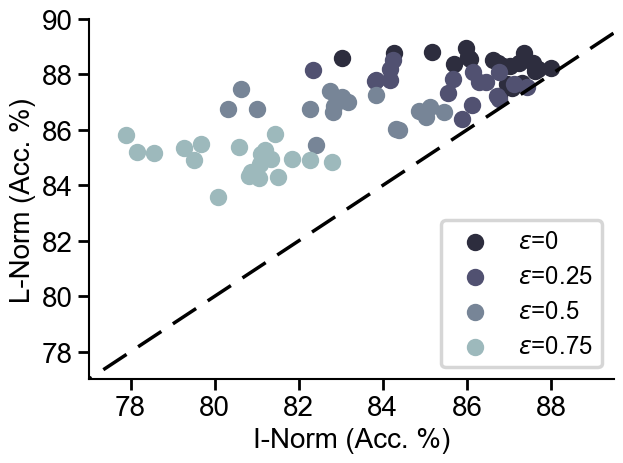

In [9]:
fig, ax = plt.subplots()

# Example brightness factors used
brightness_values = [0, 0.25, 0.5, 0.75]

# Normalize brightness for colormap mapping
norm = mcolors.Normalize(vmin=min(brightness_values), vmax=max(brightness_values))

def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Create a grayscale colormap from 20% (dark gray) to 100% (black)
cmap = truncate_colormap(plt.get_cmap('bone'), 0.2, 0.7)

scatter_handles = []  # For legend proxy if needed

list_line = range(100)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.plot(list_line, list_line, color='black', linestyle='--')
ax.set_xlabel(f"I-Norm (Acc. %)", fontsize=20)
ax.set_ylabel("L-Norm (Acc. %)", fontsize=20)

for bfi in brightness_values:
    color = cmap(norm(bfi))

    runs_dict = dict()

    runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 1, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")
    runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 1, "config.normtype": 0, "config.normtype_detach": 1, "config.lambda_homeo": 0.01,
                                                            "config.excitation_training": 1, "config.layer_norm": None, "config.feedback_alignment":0, "config.use_testset": True, "config.ln_feedback":'full'}, order="-summary_metrics.test_acc")

    top_n = len(runs_dict["runs_vanilla_dann_layernorm"])

    for top in range(top_n):
        vanilla_dann_acc = runs_dict["runs_vanilla_dann_layernorm"][top].summary['test_acc']
        for rn in runs_dict["runs_homeostasis"]:
            if same_config(rn.config, runs_dict["runs_vanilla_dann_layernorm"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                sc = ax.scatter(rn.summary['test_acc'], vanilla_dann_acc, color=color, label=f"$\epsilon$={bfi}" if top == 0 else None)
                break  # Only label once per brightness group
ax.set_xlim(77, 89.5)
ax.set_ylim(77, 90)
ax.legend()

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.savefig("figure3a.svg", format="svg")

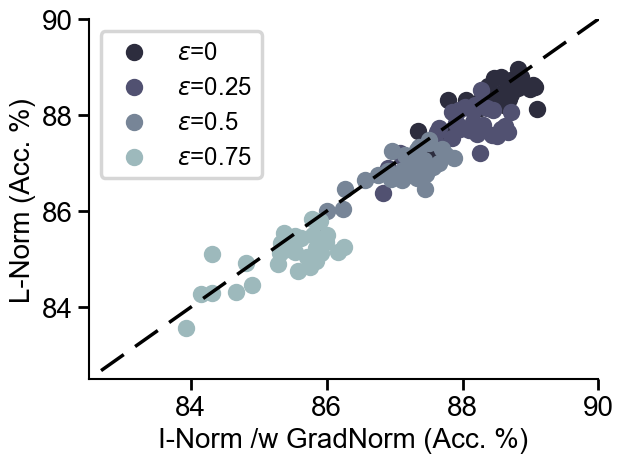

In [11]:
fig, ax = plt.subplots()

# Example brightness factors used
brightness_values = [0, 0.25, 0.5, 0.75]

# Normalize brightness for colormap mapping
norm = mcolors.Normalize(vmin=min(brightness_values), vmax=max(brightness_values))

def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Create a grayscale colormap from 20% (dark gray) to 100% (black)
cmap = truncate_colormap(plt.get_cmap('bone'), 0.2, 0.7)

scatter_handles = []  # For legend proxy if needed

list_line = range(100)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.plot(list_line, list_line, color='black', linestyle='--')
ax.set_xlabel(f"I-Norm /w GradNorm (Acc. %)", fontsize=20)
ax.set_ylabel("L-Norm (Acc. %)", fontsize=20)

for bfi in brightness_values:
    color = cmap(norm(bfi))

    runs_dict = dict()

    runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 1, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")
    runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 1, "config.normtype": 0, "config.normtype_detach": 0, "config.lambda_homeo": 0.01,
                                                            "config.excitation_training": 1, "config.layer_norm": None, "config.feedback_alignment":0, "config.use_testset": True, "config.ln_feedback":'full'}, order="-summary_metrics.test_acc")

    top_n = len(runs_dict["runs_vanilla_dann_layernorm"])

    for top in range(top_n):
        vanilla_dann_acc = runs_dict["runs_vanilla_dann_layernorm"][top].summary['test_acc']
        for rn in runs_dict["runs_homeostasis"]:
            if same_config(rn.config, runs_dict["runs_vanilla_dann_layernorm"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                sc = ax.scatter(rn.summary['test_acc'], vanilla_dann_acc, color=color, label=f"$\epsilon$={bfi}" if top == 0 else None)
                break  # Only label once per brightness group
ax.set_xlim(82.5, 90)
ax.set_ylim(82.5, 90)
ax.legend()
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Luminosity Threshold', fontsize=16)
# cbar.ax.tick_params(labelsize=14)
plt.savefig("figure3d2.svg", format="svg")